### Autoreload

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [39]:
# Task models
from dlomix.models.chargestate import DominantChargeStatePredictor
from dlomix.models.chargestate import ObservedChargeStatePredictor
# Test models
from dlomix.models.experimental_chargestate import LSTMTest
from dlomix.models.experimental_chargestate import LayerTestChargePredictor
from dlomix.models.experimental_chargestate import PrositChargeStateAdaption
# Constants
from dlomix.constants import ALPHABET_UNMOD
# libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np 

### Create dummy data

In [5]:
# read in parquet file
df = pd.read_parquet('../data/TUM_third_pool_meta_data.parquet')

In [6]:
# remove UNIMOD sequences
df = df[~df.modified_sequence.str.contains('UNIMOD')]

In [7]:
# randomly sample 10,000 rows
df = df.sample(10000)

In [8]:
# encode the sequences
df.modified_sequence = df.modified_sequence.apply(list).apply(lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x]))

In [9]:
# determine the maximum sequence length in the dummy-dataset
max_len = df.modified_sequence.apply(len).max()
max_len

32

In [10]:
# pad sequences to max length with 0s
df.modified_sequence = df.modified_sequence.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=0))

In [11]:
# drop all column exept modified_sequence and precursor_charge
df = df[['modified_sequence', 'precursor_charge']]

In [12]:
# Split into features and labels
X = np.array(df.modified_sequence.to_list())
y = df['precursor_charge'].values

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Create model objects

In [123]:
majority_model = DominantChargeStatePredictor()
majority_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [124]:
observed_model = ObservedChargeStatePredictor()
observed_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [125]:
lstm_model_test = LSTMTest()
lstm_model_test.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
all_of_it_test_model = LayerTestChargePredictor(seq_length=max_len)
all_of_it_test_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Train models on dummy data

In [15]:
# regularisation: early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

In [22]:
# test if training works for majority model
history_1 = majority_model.fit(x_train, y_train,epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

NameError: name 'majority_model' is not defined

In [129]:
# test if training works for observed model
history_2 = observed_model.fit(x_train, y_train,epochs=10, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/10
250/250 [==============================] - 0s 1ms/step - loss: 0.9065 - accuracy: 0.5819 - val_loss: 0.6878 - val_accuracy: 0.6720
Epoch 2/10
250/250 [==============================] - 0s 777us/step - loss: 0.5940 - accuracy: 0.7234 - val_loss: 0.5355 - val_accuracy: 0.7320
Epoch 3/10
250/250 [==============================] - 0s 777us/step - loss: 0.4838 - accuracy: 0.7755 - val_loss: 0.4718 - val_accuracy: 0.7815
Epoch 4/10
250/250 [==============================] - 0s 757us/step - loss: 0.4486 - accuracy: 0.7955 - val_loss: 0.4303 - val_accuracy: 0.8195
Epoch 5/10
250/250 [==============================] - 0s 753us/step - loss: 0.4265 - accuracy: 0.8069 - val_loss: 0.4246 - val_accuracy: 0.8090
Epoch 6/10
250/250 [==============================] - 0s 757us/step - loss: 0.4142 - accuracy: 0.8091 - val_loss: 0.4146 - val_accuracy: 0.8165
Epoch 7/10
250/250 [==============================] - 0s 745us/step - loss: 0.4085 - accuracy: 0.8121 - val_loss: 0.4171 - val_accuracy: 0

In [130]:
# Adjusting precursor charge -- HACK --
df['adjusted_precursor_charge'] = df.precursor_charge - 1

In [131]:
history_3 = lstm_model_test.fit(x_train, y_train,epochs=10, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/10
250/250 [==============================] - 3s 9ms/step - loss: 0.7490 - accuracy: 0.6444 - val_loss: 0.4824 - val_accuracy: 0.7645
Epoch 2/10
250/250 [==============================] - 2s 7ms/step - loss: 0.5002 - accuracy: 0.7495 - val_loss: 0.4606 - val_accuracy: 0.7810
Epoch 3/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4628 - accuracy: 0.7719 - val_loss: 0.4356 - val_accuracy: 0.7870
Epoch 4/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4544 - accuracy: 0.7724 - val_loss: 0.4846 - val_accuracy: 0.7365
Epoch 5/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4403 - accuracy: 0.7862 - val_loss: 0.4489 - val_accuracy: 0.7840
Epoch 6/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4317 - accuracy: 0.7835 - val_loss: 0.4214 - val_accuracy: 0.8000
Epoch 7/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4292 - accuracy: 0.7885 - val_loss: 0.4129 - val_accuracy: 0.8080
Epoch 

In [42]:
# WIP - not working
history_4 = all_of_it_test_model.fit(x_train, y_train,epochs=100, batch_size=16, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/100
496/500 [============================>.] - ETA: 0s - loss: 0.4949 - accuracy: 0.7578Shape of inputs:  (16, 32)
Shape after embedding:  (16, 32, 128)
Shape after bilstm:  (16, 32, 128)
Shape after attention:  (16, 32, 128)
Shape after flatten:  (16, 4096)
Shape after dense1:  (16, 64)
Shape of output:  (16, 7)


W0000 00:00:1709635048.364788    1918 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 2995 num_cores: 32 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 2097152 l3_cache_size: 37748736 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


500/500 [==============================] - 4s 8ms/step - loss: 0.4945 - accuracy: 0.7580 - val_loss: 0.4553 - val_accuracy: 0.7920
Epoch 2/100
500/500 [==============================] - 4s 8ms/step - loss: 0.4583 - accuracy: 0.7703 - val_loss: 0.4644 - val_accuracy: 0.7745
Epoch 3/100
500/500 [==============================] - 4s 8ms/step - loss: 0.4443 - accuracy: 0.7791 - val_loss: 0.4731 - val_accuracy: 0.7790
Epoch 4/100
500/500 [==============================] - 4s 8ms/step - loss: 0.4333 - accuracy: 0.7828 - val_loss: 0.4468 - val_accuracy: 0.7895
Epoch 5/100
500/500 [==============================] - 4s 8ms/step - loss: 0.4164 - accuracy: 0.7922 - val_loss: 0.4287 - val_accuracy: 0.7945
Epoch 6/100
500/500 [==============================] - 4s 8ms/step - loss: 0.4096 - accuracy: 0.7976 - val_loss: 0.4285 - val_accuracy: 0.7980
Epoch 7/100
500/500 [==============================] - 4s 8ms/step - loss: 0.3998 - accuracy: 0.8033 - val_loss: 0.4224 - val_accuracy: 0.7975
Epoch 8/100

### Reporting

In [43]:
def plot_learning_curves(history, title='Learning Curves'):
    """Plot the learning curves for training and validation loss and accuracy. 
    Args:
    - history: Return value from model.fit().
    - title (optional): Base title for the plots. It will be appended with "Loss" and "Accuracy" for the respective plots.
    """
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    # Dynamically find accuracy keys in history_dict
    accuracy_key = next((key for key in history_dict.keys() if 'acc' in key and not key.startswith('val_')), None)
    val_accuracy_key = next((key for key in history_dict.keys() if 'acc' in key and key.startswith('val_')), None)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot training and validation loss
    ax1.plot(epochs, loss, 'b', label='Training Loss')
    if val_loss:
        ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot training and validation accuracy if keys exist
    if accuracy_key and val_accuracy_key:
        accuracy = history_dict[accuracy_key]
        val_accuracy = history_dict[val_accuracy_key]
        ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
        ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
        ax2.set_title(f'{title} - Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    else:
        ax2.set_title(f'{title} - Accuracy Not Available')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.text(0.5, 0.5, 'Accuracy data not found in history', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()

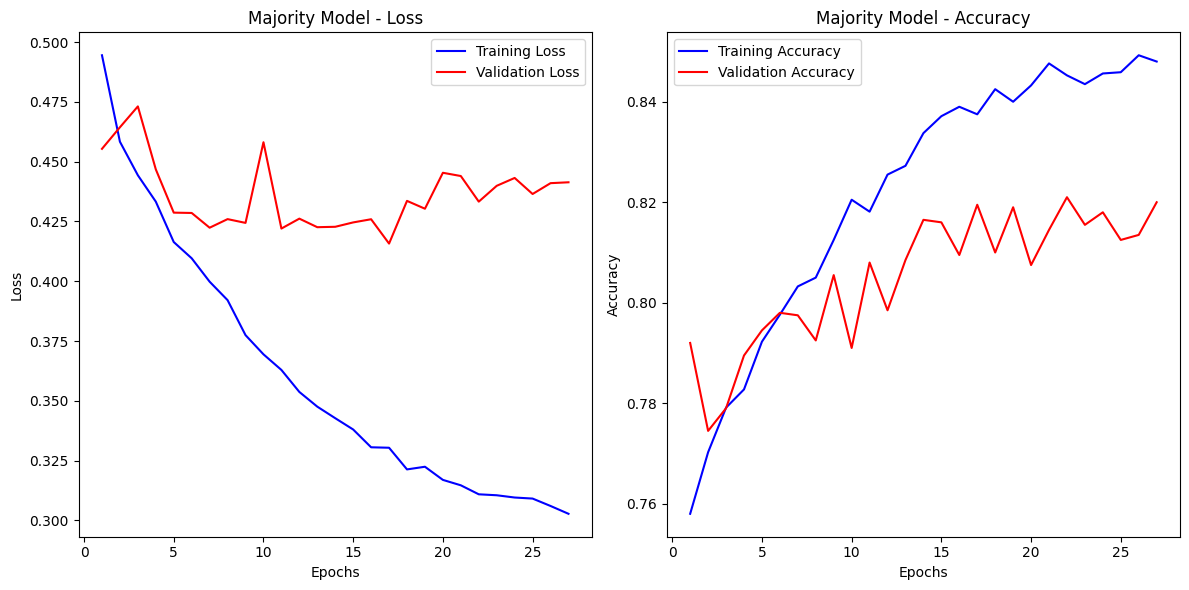

In [44]:
plot_learning_curves(history_4, title='Majority Model')

### Random Predictor baseline

### Distribution baseline